NameError: name 'files' is not defined

Epoch 1/20, Loss: 0.6953, accuracy:95.04%
Epoch 2/20, Loss: 0.5980, accuracy:98.56%
Epoch 3/20, Loss: 0.5839, accuracy:98.94%
Epoch 4/20, Loss: 0.5766, accuracy:99.14%
Epoch 5/20, Loss: 0.5713, accuracy:99.27%
Epoch 6/20, Loss: 0.5628, accuracy:99.50%
Epoch 7/20, Loss: 0.5601, accuracy:99.56%
Epoch 8/20, Loss: 0.5589, accuracy:99.58%
Epoch 9/20, Loss: 0.5576, accuracy:99.58%
Epoch 10/20, Loss: 0.5566, accuracy:99.62%
Epoch 11/20, Loss: 0.5525, accuracy:99.73%
Epoch 12/20, Loss: 0.5524, accuracy:99.72%
Epoch 13/20, Loss: 0.5515, accuracy:99.76%
Epoch 14/20, Loss: 0.5514, accuracy:99.77%
Epoch 15/20, Loss: 0.5503, accuracy:99.78%
Epoch 16/20, Loss: 0.5490, accuracy:99.81%
Epoch 17/20, Loss: 0.5487, accuracy:99.83%
Epoch 18/20, Loss: 0.5484, accuracy:99.83%
Epoch 19/20, Loss: 0.5486, accuracy:99.80%
Epoch 20/20, Loss: 0.5484, accuracy:99.83%
Test loss : 0.5355, Accuracy: 99.32%


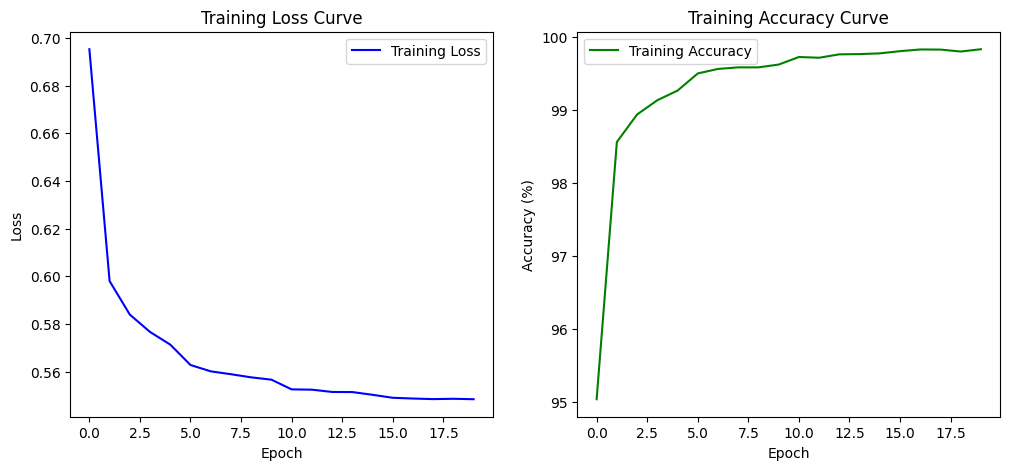

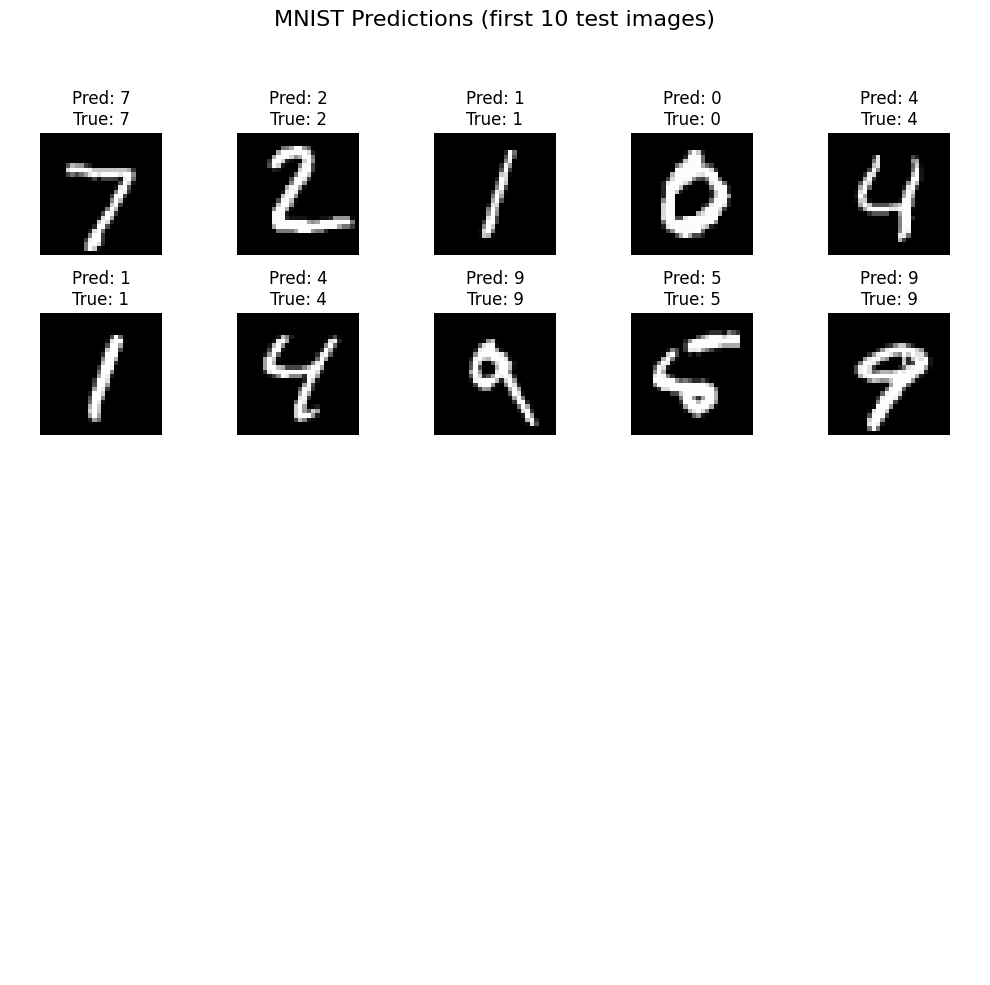

In [12]:
#importing libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./mnist_data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, pin_memory=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, pin_memory=True)
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
#creating the nn network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x14x14
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32x7x7
        )
        self.fc = nn.Sequential(
            nn.Linear(32*7*7, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


#initialising parameters
learning_rate=0.001
epoches=20

#creating model
model = CNN()
model=model.to(device)

#loss function defined
loss_fn=nn.CrossEntropyLoss(label_smoothing= 0.1)

#using optimization technique ADAM (could have used momentum ,SGD , RMS prop but found it working better)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses = []
train_accuracies = []

#starting training model
for epoch in range(epoches):
  total_epoch_loss=0
  correct=0
  total=0
  for batch_features,batch_labels in trainloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    #getting prediction from model(forward propogation)
    pred=model(batch_features)
    #calculating loss
    loss=loss_fn(pred,batch_labels)
     # zero out gradient
    optimizer.zero_grad()
    #backpropogation
    loss.backward()
    #this i also don't know the use , just found it as a solution to overcome 'exploding gradient' problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
     #call to use optimising technique and updating parameters
    optimizer.step()
     #calculating loss and accuracy
    total_epoch_loss+=loss.item()
    correct += (torch.argmax(pred,dim=1) == batch_labels).sum().item()
    total += batch_labels.size(0)
  scheduler.step()
  acc=100.*correct/total
  avg_epoch_loss=total_epoch_loss/len(trainloader)
  train_losses.append(avg_epoch_loss)
  train_accuracies.append(acc)
  print(f"Epoch {epoch+1}/{epoches}, Loss: {avg_epoch_loss:.4f}, accuracy:{acc:.2f}%")

#it is a call to tell that model will now be evaluated on test set
model.eval()

tcorrect=0
ttotal=0
tloss=0
#taking 10 images from test data for prediction
simages, slabels = next(iter(testloader))
simages, slabels = simages[:10], slabels[:10]
simages = simages.to(device)

with torch.no_grad():
  for batch_features,batch_labels in testloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    output=model(batch_features)
    loss=loss_fn(output,batch_labels)
    tloss+=loss.item()
    tcorrect+=(torch.argmax(output,dim=1)==batch_labels).sum().item()
    ttotal+=batch_labels.size(0)
avg_test_loss=tloss/len(testloader)
tacc=100.*tcorrect/ttotal

print(f"Test loss : {avg_test_loss:.4f}, Accuracy: {tacc:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.legend()

plt.show()

model.eval()
with torch.no_grad():
    soutputs = model(simages)
    _, spreds = soutputs.max(1)

simages = simages.cpu()
spreds = spreds.cpu()
slabels = slabels.cpu()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('MNIST Predictions (first 10 test images)', fontsize=16)

for i in range(25):
    ax = axes[i // 5, i % 5]
    ax.axis('off')

    if i < 10:
        img = simages[i].squeeze(0)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {spreds[i]}\nTrue: {slabels[i]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()